# Russian cursive classifier
made by **Anton Korotkov**

## Project idea
- To research which ML ANN approach is the best to recognize russian cursive letters.
- Create a web-interface, where user could draw a letter and a model would guess it.

---


## Realization

First, we need to install all needed libraries

In [27]:
%pip install seaborn
%pip install torch
%pip install torchvision
%pip install matplotlib
%pip install numpy
%pip install sklearn
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  G

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


And then, import them.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Subset
from tqdm import tqdm
import os
from PIL import Image

### Data preprocessing
- Here we use inherited dataset class for proper preprocessing.
- Applying transformations to standartisize our images and convert them to the same size, colormap, and tensor them.
- Splitting them 70%-15%-15% on train, validation and test datasets respectively. 
- Converting datasets to DataLoaders for useful model training.

In [29]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['file']
        label = self.data.iloc[idx]['label'] - 1
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label


# Transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

batch_size = 32
csv_path = 'all_letters_info.csv'
img_dir = 'all_letters_image'

dataset = ImageDataset(csv_path=csv_path, img_dir=img_dir, transform=transform)

labels = pd.read_csv(csv_path)['label']
indeces = list(range(len(labels)))
train_val_idx, test_idx = train_test_split(indeces, test_size=0.15, stratify=labels, random_state=42)

train_val_labels = [labels[i] for i in train_val_idx]

train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1765, stratify=train_val_labels, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Now we can check our letters

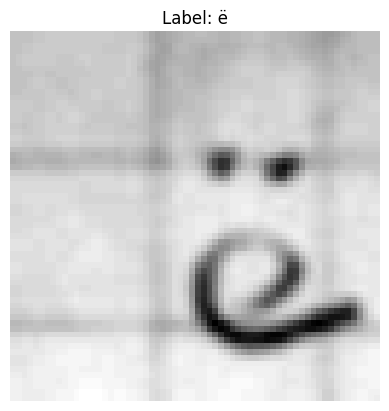

In [30]:
image, label = dataset[332]

image = image.squeeze(0) # Reduce the dimensions to 2D for visualization

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'[label]}')
plt.axis('off')
plt.show()

## Models configuration

### MLP
- Multi-layer-perceptron network
- 4 layers with DropOut
- Training function with validation and history saving
- Validation function

In [31]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(64*64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 33)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=33, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Specifying the **device** our model will work on.

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
def validate(mlp, val_loader):
    mlp.eval()
    total = 0
    correct = 0
    loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            Images = images.to(device)
            Labels = labels.to(device)
            outputs = mlp(Images)
            _, predicted = torch.max(outputs, 1)
            total += Labels.size(0)
            correct += (predicted == Labels).sum().item()
            accuracy = 100 * correct / total
            loss += F.cross_entropy(outputs, Labels).item()
    return accuracy, loss / len(val_loader)

In [34]:
def train(mlp, train_loader, val_loader, lr, epochs):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [],  'val_acc': []
    }

    optimizer = optim.Adam(mlp.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    mlp.train()

    for epoch in range(epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        bar = tqdm(train_loader)
        for images, labels in bar:
            images = images.to(device)
            labels.view(-1).long().to(device)

            optimizer.zero_grad()
            outputs = mlp(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
            bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_acc = 100* correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_acc, val_loss = validate(mlp, val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}')
        accuracy = validate(mlp, val_loader)
        print(f'Validation Accuracy: {accuracy[0]:.2f}%')
    return history
mlp_history = train(model, train_loader, val_loader, lr=0.001, epochs=50)


Epoch [1/50]: 100%|██████████| 311/311 [00:15<00:00, 19.51it/s, loss=3.45]


Epoch [1/50], Loss: 3.4765
Validation Accuracy: 4.79%


Epoch [2/50]: 100%|██████████| 311/311 [00:11<00:00, 27.25it/s, loss=3.01]


Epoch [2/50], Loss: 3.3400
Validation Accuracy: 11.09%


Epoch [3/50]: 100%|██████████| 311/311 [00:11<00:00, 27.91it/s, loss=2.82]


Epoch [3/50], Loss: 2.9603
Validation Accuracy: 21.14%


Epoch [4/50]: 100%|██████████| 311/311 [00:11<00:00, 28.03it/s, loss=2.39]


Epoch [4/50], Loss: 2.6734
Validation Accuracy: 25.83%


Epoch [5/50]: 100%|██████████| 311/311 [00:11<00:00, 28.00it/s, loss=2.99]


Epoch [5/50], Loss: 2.4289
Validation Accuracy: 29.78%


Epoch [6/50]: 100%|██████████| 311/311 [00:11<00:00, 27.82it/s, loss=1.73]


Epoch [6/50], Loss: 2.2066
Validation Accuracy: 32.32%


Epoch [7/50]: 100%|██████████| 311/311 [00:11<00:00, 28.10it/s, loss=1.15]


Epoch [7/50], Loss: 2.0761
Validation Accuracy: 38.99%


Epoch [8/50]: 100%|██████████| 311/311 [00:11<00:00, 28.11it/s, loss=1.4] 


Epoch [8/50], Loss: 1.9470
Validation Accuracy: 40.86%


Epoch [9/50]: 100%|██████████| 311/311 [00:11<00:00, 27.31it/s, loss=1.99]


Epoch [9/50], Loss: 1.8669
Validation Accuracy: 43.26%


Epoch [10/50]: 100%|██████████| 311/311 [00:11<00:00, 27.98it/s, loss=1.36]


Epoch [10/50], Loss: 1.7888
Validation Accuracy: 44.57%


Epoch [11/50]: 100%|██████████| 311/311 [00:11<00:00, 28.06it/s, loss=1.86] 


Epoch [11/50], Loss: 1.7108
Validation Accuracy: 42.41%


Epoch [12/50]: 100%|██████████| 311/311 [00:11<00:00, 28.20it/s, loss=1.49] 


Epoch [12/50], Loss: 1.6109
Validation Accuracy: 45.00%


Epoch [13/50]: 100%|██████████| 311/311 [00:11<00:00, 28.14it/s, loss=0.865]


Epoch [13/50], Loss: 1.5586
Validation Accuracy: 44.11%


Epoch [14/50]: 100%|██████████| 311/311 [00:11<00:00, 28.18it/s, loss=1.1]  


Epoch [14/50], Loss: 1.4727
Validation Accuracy: 50.02%


Epoch [15/50]: 100%|██████████| 311/311 [00:11<00:00, 27.79it/s, loss=1.04] 


Epoch [15/50], Loss: 1.3962
Validation Accuracy: 50.02%


Epoch [16/50]: 100%|██████████| 311/311 [00:11<00:00, 28.08it/s, loss=1.83] 


Epoch [16/50], Loss: 1.3550
Validation Accuracy: 51.39%


Epoch [17/50]: 100%|██████████| 311/311 [00:11<00:00, 28.10it/s, loss=1.38] 


Epoch [17/50], Loss: 1.2982
Validation Accuracy: 49.08%


Epoch [18/50]: 100%|██████████| 311/311 [00:11<00:00, 27.53it/s, loss=1.27] 


Epoch [18/50], Loss: 1.2871
Validation Accuracy: 52.37%


Epoch [19/50]: 100%|██████████| 311/311 [00:11<00:00, 28.08it/s, loss=0.765]


Epoch [19/50], Loss: 1.2024
Validation Accuracy: 53.83%


Epoch [20/50]: 100%|██████████| 311/311 [00:11<00:00, 28.18it/s, loss=0.937]


Epoch [20/50], Loss: 1.1644
Validation Accuracy: 54.58%


Epoch [21/50]: 100%|██████████| 311/311 [00:11<00:00, 28.17it/s, loss=1.62] 


Epoch [21/50], Loss: 1.1262
Validation Accuracy: 51.62%


Epoch [22/50]: 100%|██████████| 311/311 [00:11<00:00, 28.20it/s, loss=0.963]


Epoch [22/50], Loss: 1.0861
Validation Accuracy: 51.95%


Epoch [23/50]: 100%|██████████| 311/311 [00:11<00:00, 28.11it/s, loss=1.07] 


Epoch [23/50], Loss: 1.0871
Validation Accuracy: 51.57%


Epoch [24/50]: 100%|██████████| 311/311 [00:10<00:00, 28.29it/s, loss=0.549]


Epoch [24/50], Loss: 1.0312
Validation Accuracy: 53.17%


Epoch [25/50]: 100%|██████████| 311/311 [00:11<00:00, 28.04it/s, loss=1.75] 


Epoch [25/50], Loss: 0.9827
Validation Accuracy: 54.58%


Epoch [26/50]: 100%|██████████| 311/311 [00:11<00:00, 27.94it/s, loss=0.849]


Epoch [26/50], Loss: 0.9811
Validation Accuracy: 54.58%


Epoch [27/50]: 100%|██████████| 311/311 [00:11<00:00, 28.08it/s, loss=1.32] 


Epoch [27/50], Loss: 0.9502
Validation Accuracy: 55.94%


Epoch [28/50]: 100%|██████████| 311/311 [00:11<00:00, 27.46it/s, loss=1.14] 


Epoch [28/50], Loss: 0.9335
Validation Accuracy: 56.27%


Epoch [29/50]: 100%|██████████| 311/311 [00:11<00:00, 28.24it/s, loss=0.52] 


Epoch [29/50], Loss: 0.8915
Validation Accuracy: 54.63%


Epoch [30/50]: 100%|██████████| 311/311 [00:11<00:00, 28.19it/s, loss=1.49] 


Epoch [30/50], Loss: 0.8902
Validation Accuracy: 55.33%


Epoch [31/50]: 100%|██████████| 311/311 [00:11<00:00, 28.19it/s, loss=0.804]


Epoch [31/50], Loss: 0.8743
Validation Accuracy: 54.77%


Epoch [32/50]: 100%|██████████| 311/311 [00:11<00:00, 27.34it/s, loss=0.654]


Epoch [32/50], Loss: 0.8463
Validation Accuracy: 54.58%


Epoch [33/50]: 100%|██████████| 311/311 [00:11<00:00, 28.18it/s, loss=0.764]


Epoch [33/50], Loss: 0.7886
Validation Accuracy: 55.24%


Epoch [34/50]: 100%|██████████| 311/311 [00:11<00:00, 28.22it/s, loss=1.17] 


Epoch [34/50], Loss: 0.8220
Validation Accuracy: 56.65%


Epoch [35/50]: 100%|██████████| 311/311 [00:11<00:00, 28.03it/s, loss=1.1]  


Epoch [35/50], Loss: 0.7958
Validation Accuracy: 55.57%


Epoch [36/50]: 100%|██████████| 311/311 [00:11<00:00, 27.79it/s, loss=0.534]


Epoch [36/50], Loss: 0.7691
Validation Accuracy: 54.34%


Epoch [37/50]: 100%|██████████| 311/311 [00:11<00:00, 28.27it/s, loss=1.23] 


Epoch [37/50], Loss: 0.7765
Validation Accuracy: 57.16%


Epoch [38/50]: 100%|██████████| 311/311 [00:11<00:00, 28.13it/s, loss=0.584]


Epoch [38/50], Loss: 0.7322
Validation Accuracy: 56.51%


Epoch [39/50]: 100%|██████████| 311/311 [00:11<00:00, 28.17it/s, loss=0.529]


Epoch [39/50], Loss: 0.7472
Validation Accuracy: 57.21%


Epoch [40/50]: 100%|██████████| 311/311 [00:11<00:00, 27.46it/s, loss=0.143]


Epoch [40/50], Loss: 0.7279
Validation Accuracy: 55.80%


Epoch [41/50]: 100%|██████████| 311/311 [00:11<00:00, 28.25it/s, loss=1.35] 


Epoch [41/50], Loss: 0.6863
Validation Accuracy: 53.50%


Epoch [42/50]: 100%|██████████| 311/311 [00:11<00:00, 27.81it/s, loss=0.697]


Epoch [42/50], Loss: 0.7169
Validation Accuracy: 56.55%


Epoch [43/50]: 100%|██████████| 311/311 [00:11<00:00, 28.14it/s, loss=1.31] 


Epoch [43/50], Loss: 0.6946
Validation Accuracy: 57.87%


Epoch [44/50]: 100%|██████████| 311/311 [00:11<00:00, 28.19it/s, loss=0.478]


Epoch [44/50], Loss: 0.6916
Validation Accuracy: 57.54%


Epoch [45/50]: 100%|██████████| 311/311 [00:11<00:00, 27.59it/s, loss=0.723]


Epoch [45/50], Loss: 0.6632
Validation Accuracy: 56.22%


Epoch [46/50]: 100%|██████████| 311/311 [00:11<00:00, 28.18it/s, loss=1.02] 


Epoch [46/50], Loss: 0.6487
Validation Accuracy: 57.16%


Epoch [47/50]: 100%|██████████| 311/311 [00:11<00:00, 28.08it/s, loss=0.972]


Epoch [47/50], Loss: 0.6718
Validation Accuracy: 57.91%


Epoch [48/50]: 100%|██████████| 311/311 [00:10<00:00, 28.30it/s, loss=1.08] 


Epoch [48/50], Loss: 0.6857
Validation Accuracy: 54.49%


Epoch [49/50]: 100%|██████████| 311/311 [00:11<00:00, 28.09it/s, loss=1.07] 


Epoch [49/50], Loss: 0.6548
Validation Accuracy: 59.51%


Epoch [50/50]: 100%|██████████| 311/311 [00:11<00:00, 28.12it/s, loss=1.11] 


Epoch [50/50], Loss: 0.6016
Validation Accuracy: 59.75%


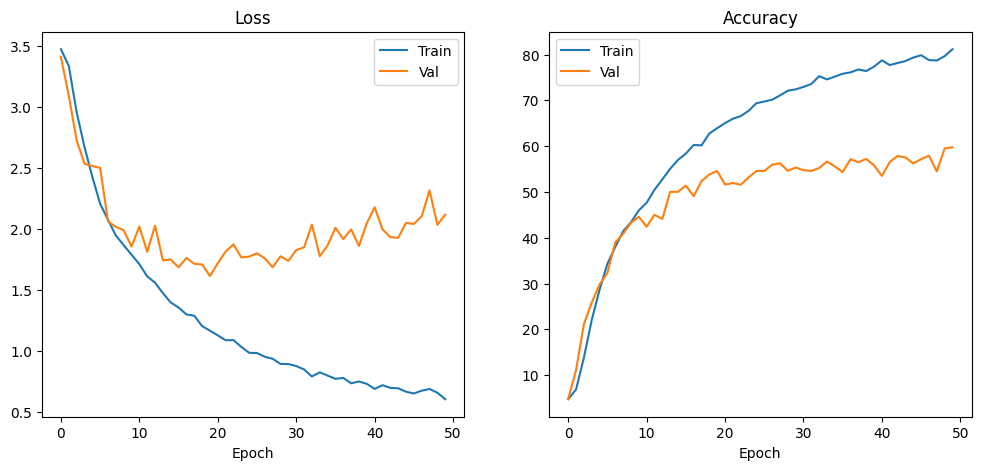

In [35]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mlp_history['train_loss'], label='Train')
plt.plot(mlp_history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_history['train_acc'], label='Train')
plt.plot(mlp_history['val_acc'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Analysis**:
- underfitting
- too long training
- not enough power for our purposes

In [36]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(64*512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 33)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
model = CNN_1D().to(device)
print(model)


CNN_1D(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear

In [37]:
criterion = nn.CrossEntropyLoss()
def validate(cnn, val_loader):
    cnn.eval()
    total = 0
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            Images = images.to(device)
            Labels = labels.to(device)
            outputs = cnn(Images)
            total_loss += criterion(outputs, Labels).item()
            _,predicted = torch.max(outputs, 1)
            total += Labels.size(0)
            correct += (predicted == Labels).sum().item()
    loss = total_loss/len(val_loader)
    accuracy = 100 * correct / total
    return loss, accuracy

In [38]:
def train(cnn, train_loader, val_loader, lr, epochs):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [],  'val_acc': []
    }

    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    cnn.train()
    for epoch in range(epochs):
        correct = 0
        total = 0
        total_loss=0
        bar = tqdm(train_loader)
        for images, labels in bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs= cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
            bar.set_postfix(loss=loss.item())

        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = validate(cnn, val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    return history

history1d = train(model, train_loader, val_loader, lr=0.001, epochs=20)

Epoch [18/20]:  80%|████████  | 249/311 [3:12:25<47:54, 46.37s/it, loss=0.0131]      


KeyboardInterrupt: 

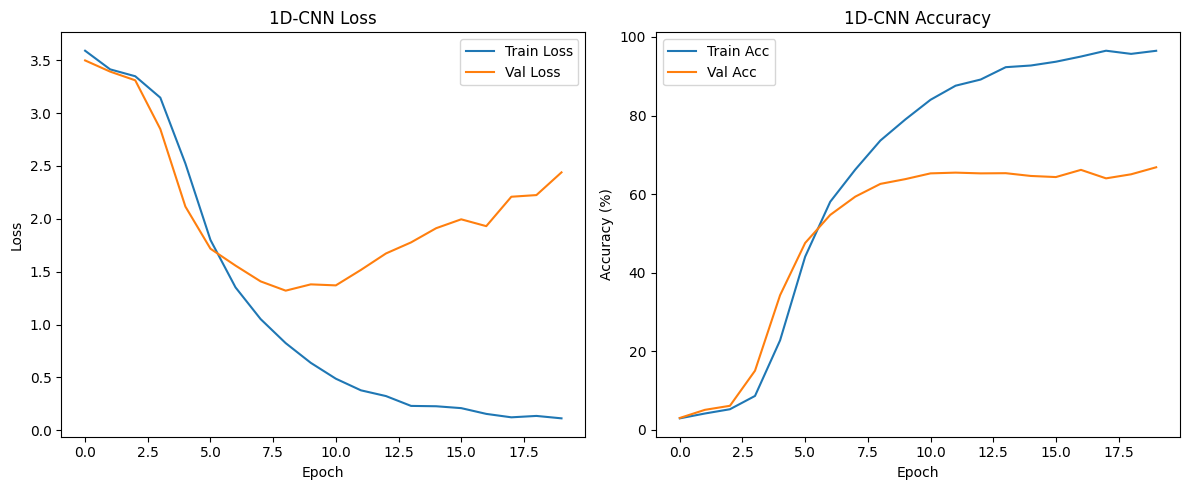

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history1d['train_loss'], label='Train Loss')
plt.plot(history1d['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('1D-CNN Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history1d['train_acc'], label='Train Acc')
plt.plot(history1d['val_acc'],   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('1D-CNN Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 1) Определяем 2D-CNN
class CNN_2D(nn.Module):
    def __init__(self, num_classes=33):
        super(CNN_2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1×64×64 → 32×64×64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 32×32×32
            nn.Dropout2d(0.5)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # → 64×32×32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 64×16×16
            nn.Dropout2d(0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# → 128×16×16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 128×8×8
            nn.Dropout2d(0.5)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

model2d = CNN_2D(num_classes=33).to(device)
print(model2d)

CNN_2D(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear

In [41]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_corr, total_samples = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            total_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            total_corr += (preds == labels).sum().item()
            total_samples += labels.size(0)
    return total_loss / len(dataloader), 100.0 * total_corr / total_samples

In [ ]:
def train_model(model, train_loader, val_loader, lr=1e-3, epochs=30, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [],  'val_acc': []
    }

    for epoch in range(1, epochs+1):
        model.train()
        running_loss, running_corr, running_samples = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            running_corr += (preds == labels).sum().item()
            running_samples += labels.size(0)
            pbar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_acc  = 100.0 * running_corr / running_samples
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}% | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.2f}%")

    return history

history2d = train_model(model2d, train_loader, val_loader, lr=1e-3, epochs=50, device=device)

Epoch 1/30: 100%|██████████| 311/311 [00:41<00:00,  7.57it/s, loss=3.19]


Epoch 1: train_loss=3.4743, train_acc=5.32% | val_loss=3.2225, val_acc=9.07%


Epoch 2/30: 100%|██████████| 311/311 [00:43<00:00,  7.21it/s, loss=3.31]


Epoch 2: train_loss=3.1851, train_acc=9.43% | val_loss=2.8939, val_acc=13.53%


Epoch 3/30: 100%|██████████| 311/311 [00:41<00:00,  7.43it/s, loss=2.89]


Epoch 3: train_loss=2.9477, train_acc=13.85% | val_loss=2.5619, val_acc=23.49%


Epoch 4/30: 100%|██████████| 311/311 [00:42<00:00,  7.33it/s, loss=2.94]


Epoch 4: train_loss=2.7440, train_acc=19.05% | val_loss=2.4114, val_acc=32.08%


Epoch 5/30: 100%|██████████| 311/311 [00:41<00:00,  7.41it/s, loss=2.34]


Epoch 5: train_loss=2.5765, train_acc=22.98% | val_loss=2.1510, val_acc=35.93%


Epoch 6/30: 100%|██████████| 311/311 [00:41<00:00,  7.45it/s, loss=2.38]


Epoch 6: train_loss=2.4081, train_acc=27.93% | val_loss=1.9349, val_acc=45.61%


Epoch 7/30: 100%|██████████| 311/311 [00:43<00:00,  7.12it/s, loss=1.79]


Epoch 7: train_loss=2.2448, train_acc=32.17% | val_loss=1.8027, val_acc=48.85%


Epoch 8/30: 100%|██████████| 311/311 [00:41<00:00,  7.55it/s, loss=1.89]


Epoch 8: train_loss=2.1230, train_acc=35.62% | val_loss=1.6468, val_acc=56.27%


Epoch 9/30: 100%|██████████| 311/311 [00:43<00:00,  7.19it/s, loss=2.04]


Epoch 9: train_loss=1.9660, train_acc=39.63% | val_loss=1.4305, val_acc=62.19%


Epoch 10/30: 100%|██████████| 311/311 [00:53<00:00,  5.78it/s, loss=1.23]


Epoch 10: train_loss=1.8123, train_acc=44.73% | val_loss=1.2543, val_acc=67.68%


Epoch 11/30: 100%|██████████| 311/311 [00:42<00:00,  7.30it/s, loss=1.33] 


Epoch 11: train_loss=1.6766, train_acc=49.12% | val_loss=1.1157, val_acc=68.86%


Epoch 12/30: 100%|██████████| 311/311 [00:45<00:00,  6.84it/s, loss=1.9]  


Epoch 12: train_loss=1.5425, train_acc=53.11% | val_loss=1.0467, val_acc=70.97%


Epoch 13/30: 100%|██████████| 311/311 [01:05<00:00,  4.72it/s, loss=0.83] 


Epoch 13: train_loss=1.4474, train_acc=56.03% | val_loss=0.9742, val_acc=74.45%


Epoch 14/30: 100%|██████████| 311/311 [00:48<00:00,  6.38it/s, loss=0.845]


Epoch 14: train_loss=1.3311, train_acc=59.14% | val_loss=0.8541, val_acc=77.45%


Epoch 15/30: 100%|██████████| 311/311 [00:49<00:00,  6.31it/s, loss=0.793]


Epoch 15: train_loss=1.2435, train_acc=61.76% | val_loss=0.8453, val_acc=77.36%


Epoch 16/30: 100%|██████████| 311/311 [00:47<00:00,  6.55it/s, loss=0.508]


Epoch 16: train_loss=1.1959, train_acc=63.01% | val_loss=0.7704, val_acc=79.90%


Epoch 17/30: 100%|██████████| 311/311 [01:00<00:00,  5.16it/s, loss=1.21] 


Epoch 17: train_loss=1.1128, train_acc=65.97% | val_loss=0.7323, val_acc=79.94%


Epoch 18/30: 100%|██████████| 311/311 [00:46<00:00,  6.64it/s, loss=1.76] 


Epoch 18: train_loss=1.0446, train_acc=67.80% | val_loss=0.6633, val_acc=82.67%


Epoch 19/30: 100%|██████████| 311/311 [00:41<00:00,  7.53it/s, loss=0.821]


Epoch 19: train_loss=0.9982, train_acc=69.64% | val_loss=0.6256, val_acc=83.80%


Epoch 20/30: 100%|██████████| 311/311 [00:40<00:00,  7.68it/s, loss=1.24] 


Epoch 20: train_loss=0.9458, train_acc=70.99% | val_loss=0.5469, val_acc=85.39%


Epoch 21/30: 100%|██████████| 311/311 [00:40<00:00,  7.65it/s, loss=1.34] 


Epoch 21: train_loss=0.8852, train_acc=73.02% | val_loss=0.5976, val_acc=84.73%


Epoch 22/30: 100%|██████████| 311/311 [00:40<00:00,  7.63it/s, loss=0.623]


Epoch 22: train_loss=0.8546, train_acc=73.79% | val_loss=0.5256, val_acc=85.39%


Epoch 23/30: 100%|██████████| 311/311 [00:40<00:00,  7.64it/s, loss=0.993]


Epoch 23: train_loss=0.8146, train_acc=74.79% | val_loss=0.4924, val_acc=86.14%


Epoch 24/30: 100%|██████████| 311/311 [00:40<00:00,  7.66it/s, loss=0.556]


Epoch 24: train_loss=0.7626, train_acc=76.65% | val_loss=0.4614, val_acc=86.99%


Epoch 25/30: 100%|██████████| 311/311 [00:40<00:00,  7.65it/s, loss=0.325]


Epoch 25: train_loss=0.7407, train_acc=76.87% | val_loss=0.4575, val_acc=86.99%


Epoch 26/30: 100%|██████████| 311/311 [00:40<00:00,  7.68it/s, loss=1.34] 


Epoch 26: train_loss=0.7023, train_acc=78.31% | val_loss=0.4436, val_acc=86.43%


Epoch 27/30: 100%|██████████| 311/311 [00:40<00:00,  7.70it/s, loss=0.242]


Epoch 27: train_loss=0.6733, train_acc=78.95% | val_loss=0.4263, val_acc=87.74%


Epoch 28/30: 100%|██████████| 311/311 [00:40<00:00,  7.67it/s, loss=0.657]


Epoch 28: train_loss=0.6411, train_acc=79.80% | val_loss=0.3967, val_acc=88.40%


Epoch 29/30: 100%|██████████| 311/311 [00:40<00:00,  7.72it/s, loss=0.74] 


Epoch 29: train_loss=0.6448, train_acc=80.25% | val_loss=0.4180, val_acc=87.60%


Epoch 30/30: 100%|██████████| 311/311 [00:40<00:00,  7.69it/s, loss=0.526]


Epoch 30: train_loss=0.6156, train_acc=80.86% | val_loss=0.4059, val_acc=87.83%


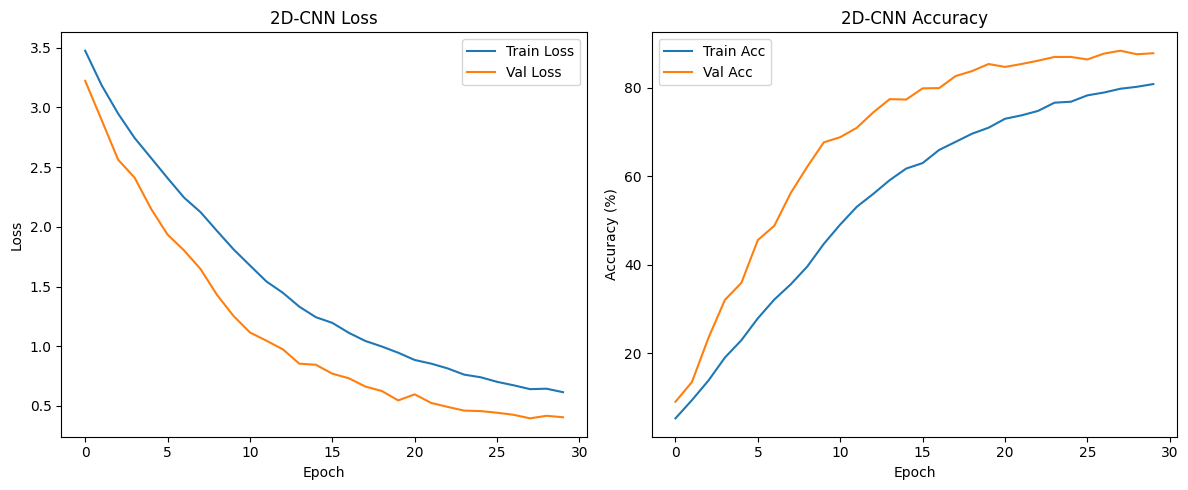

In [39]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history2d['train_loss'], label='Train Loss')
plt.plot(history2d['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('2D-CNN Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history2d['train_acc'], label='Train Acc')
plt.plot(history2d['val_acc'],   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('2D-CNN Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
validate(model2d, test_loader, criterion, device)

(0.42198224799401723, 88.2573978393612)

In [43]:
torch.save(model2d.state_dict(), 'my_model2d_weights.pth')